In [1]:
%load_ext autoreload
%autoreload 2

In [7]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from src.bioreactor import simulate, plot_simulation, plot_feeding, generate_training_data

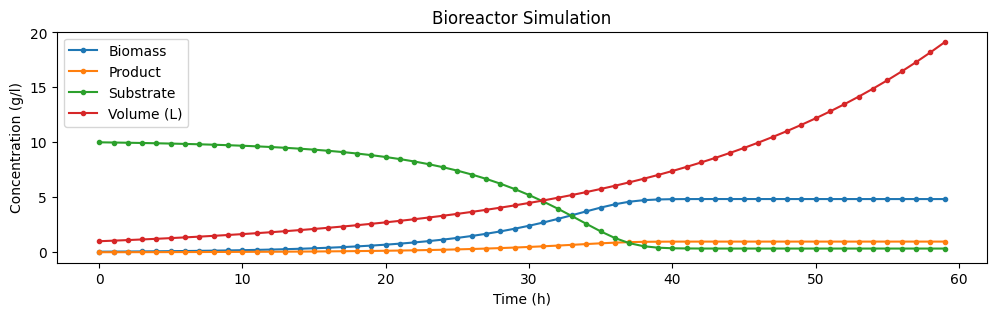

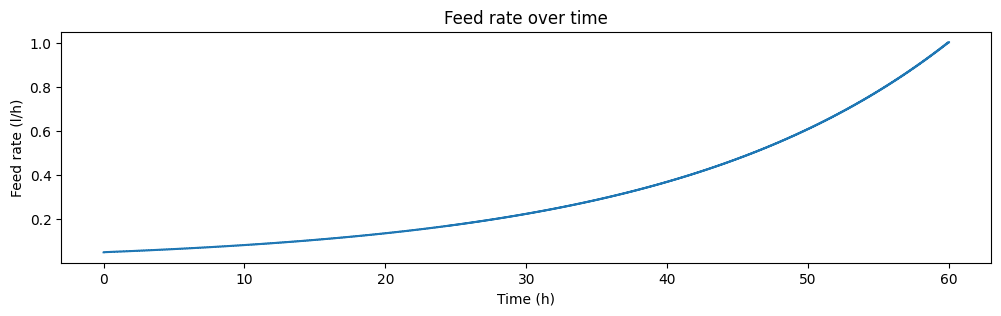

In [19]:
df = simulate()
plot_simulation(df)
plot_feeding()

In [49]:
train_df = generate_training_data(samples=10000)

100%|██████████| 10000/10000 [00:19<00:00, 511.22it/s]


100%|██████████| 59/59 [00:00<00:00, 7477.38it/s]


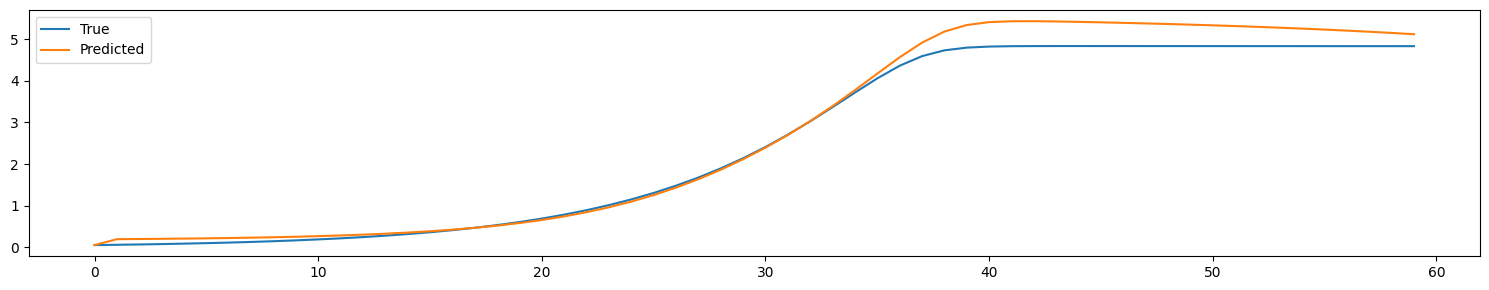

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from src.bioreactor import *

X = train_df[['F', 'X']].values
y = train_df[['X_next']].values.reshape(-1,)

# Create and fit the model
model = SVR(C=0.5).fit(X, y)
model.fit(X, y)

# Validate model on experimental data
test_df = df[['F', 'X']]
F_test = [df['F'].values[0]]
X_test = [df['X'].values[0]]

for i in tqdm(range(1, len(df))):
    preds = model.predict([[df['F'].values[i-1], df['X'].values[i-1]]])
    F_test.append(df['F'].values[i])
    X_test.append(preds[0])
    
# -- Plotting --
plt.figure(figsize=(15, 3))
plt.plot(df['X'], label='True')
plt.plot(X_test, label='Predicted')
plt.legend()
plt.tight_layout()
plt.show()

In [57]:
# X_ref = [10 for _ in range(L)]
X_ref = df['X'].values.tolist()
X, P, S, V, F = simulation(model, X_ref)

  0%|          | 0/60 [00:00<?, ?it/s]

100%|██████████| 60/60 [00:02<00:00, 23.30it/s]


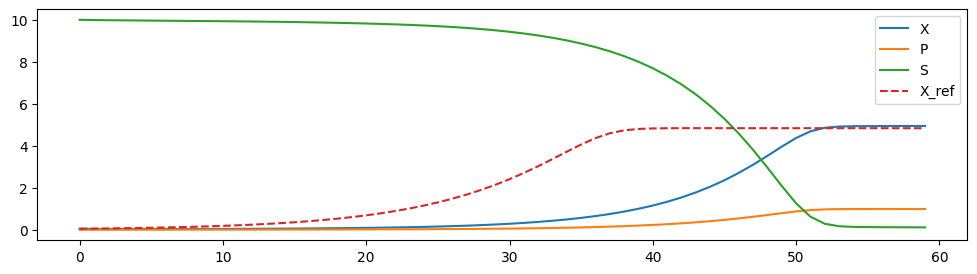

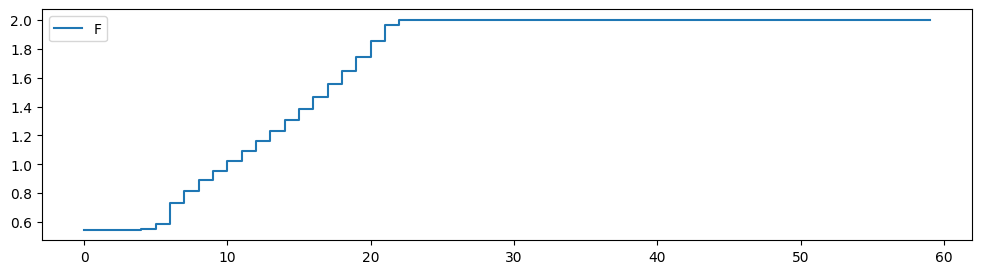

In [58]:
from scipy.integrate import odeint
from scipy.interpolate import interp1d

def dynamic_system(t, y):
    # [X0, P0, S0, V0]
    X, P, S, V = y
    F = F_func(t)
    dX = mu(S) * X - F * X / V
    dS = -mu(S) * X / Y_XS + F * (S_F - S) / V
    dP = Y_PX * mu(S) * X - F * P / V
    dV = F
    return [dX, dP, dS, dV]

t_points = np.arange(0, L, dt)
F_func = interp1d(t_points, F, kind='linear', fill_value='extrapolate')
t_span = (0, L)
y0 = [X[0], P[0], S[0], V[0]]
sol_t = [0]
sol_X = [X[0]]
sol_P = [P[0]]
sol_S = [S[0]]
sol_V = [V[0]]

for i in range(len(t_points)-1):
    sol = solve_ivp(dynamic_system, [t_points[i], t_points[i+1]], y0)
    y0 = sol.y[:,-1]
    sol_t.append(t_points[i+1])
    sol_X.append(y0[0])
    sol_P.append(y0[1])
    sol_S.append(y0[2])
    sol_V.append(y0[3])
    
sol_df = pd.DataFrame({'t': sol_t, 'X': sol_X, 'P': sol_P, 'S': sol_S, 'V': sol_V})
sol_df['F'] = F_func(sol_df['t'])

# -- Plotting --
plt.figure(figsize=(12, 3))
plt.plot(sol_df['t'], sol_df['X'], label='X')
plt.plot(sol_df['t'], sol_df['P'], label='P')
plt.plot(sol_df['t'], sol_df['S'], label='S')
plt.plot(X_ref, label='X_ref', linestyle='--')
plt.legend()
plt.show()

plt.figure(figsize=(12, 3)) 
plt.step(sol_df['t'], sol_df['F'], label='F')
plt.legend()
plt.show()